Epoch 1/50


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1828/1828 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - loss: 4.6569 - val_loss: 1.0641
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 1.3094 - val_loss: 0.9815
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 1.1420 - val_loss: 0.9442
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 1.0506 - val_loss: 0.9399
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 1.0327 - val_loss: 0.9294
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 1.0074 - val_loss: 0.9249
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - loss: 0.9784 - val_loss: 0.9270
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - loss: 0.9633 - val_loss: 0.9333
Epoch 9/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - loss: 0.9509 - val_loss: 0.9307
Epoch 10/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 0.9453 - val_loss: 0.9246
Epoch 11/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 0.9499 - val_loss: 0.9290
Epoch 12/50
1828/18

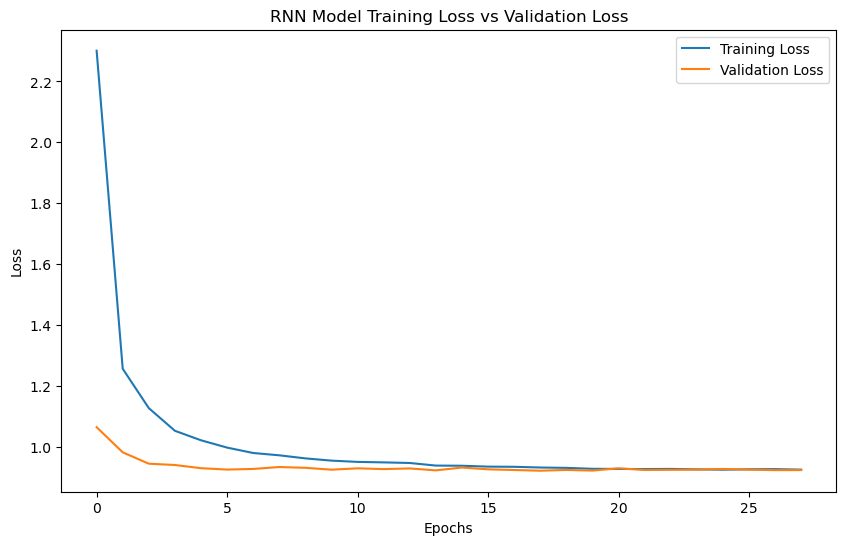

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('retail_store_inventory.csv')

# Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Categorical feature columns
categorical_features = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Holiday/Promotion', 'Seasonality']

# Convert categorical features to numeric using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col])

# Drop 'Date' and 'Demand Forecast' from features and target 'Units Sold'
X = df.drop(['Units Sold', 'Demand Forecast', 'Date'], axis=1)
y = df['Units Sold']

# Feature Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Reshape target to match the required format
y_log = np.log1p(y)  # Apply log transformation to the target

# Train-Test Split (Make sure target and features are aligned)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, shuffle=False)

# Reshape the data for RNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(Dense(1))  # Output layer (predicting 'Units Sold')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Predict the results
y_pred_log = model.predict(X_test)

# Reverse the log transformation to get actual values
y_pred = np.expm1(y_pred_log)  # Apply inverse log transformation
y_test_original = np.expm1(y_test)  # Inverse log transformation for the true values

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()